# Stable Diffusion with Repeatable Seeds

This example shows how to use the Stable Diffusion pipeline to tweak generated images using repeatable seeds.

## Setup

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In [2]:
!nvidia-smi

Thu Aug 25 12:19:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install diffusers and required libraries.

**TODO**: replace when merged.

In [3]:
!pip install git+https://github.com/huggingface/diffusers.git@refs/pull/247/head
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/diffusers.git (to revision refs/pull/247/head) to /tmp/pip-req-build-bvfry7ye
  Running command git clone -q https://github.com/huggingface/diffusers.git /tmp/pip-req-build-bvfry7ye
  Running command git fetch -q https://github.com/huggingface/diffusers.git refs/pull/247/head
  Running command git checkout -q 71127e2573ff7dcd7e8a136513ff54bbf7d36eb4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This demo uses Stable Diffusion. The model weights are released under a permissive license that you have to accept. Please, visit the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), carefully read the license and accept it only if you agree with all its terms. You have to be a registered user in 🤗 Hugging Face Hub to do so.

If you accept the license, you also need to use an access token to access the weights. This is so 🤗 Hugging Face Hub can verify that you indeed accepted the license. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In order to authenticate against the Hub, please run the following cell. We first need to enable externarl widgets because Google Colab recently disabled them; then we trigger an authentication with your user token.

In [29]:
from google.colab import output
output.enable_custom_widget_manager()

from huggingface_hub import notebook_login
notebook_login()

## Stable Diffusion Pipeline

We use the half-float precision to save GPU memory. If you want to run inference at full precision, just remove `revision="fp16"` and `torch_dtype=torch.float16` from the cell below.

In [5]:
import torch
from diffusers import StableDiffusionPipeline

device = "cuda"
model_id = "CompVis/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True,
).to(device)

We'll first generate a few images to see which one we like the most. In order to view them nicely, we'll create a helper function to present results in a grid. This was taken from the 🤗 Hugging Face [Stable Diffusion blog post](https://huggingface.co/blog/stable_diffusion).

In [6]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


In this example we are going to generate 4 images at once. Feel free to update it depending on how much RAM your GPU has. We also set the desired output resolution to `512 × 512`.

In [7]:
num_images = 4

width = 512
height = 512

### Latents Generation

In order to reuse the seeds we need to generate the latents ourselves. Otherwise, the pipeline will do it internally and we won't have a way to replicate them.

Latents are the initial random Gaussian noise that gets transformed to actual images during the diffusion process.

To generate them, we'll use a different random seed for each latent, and we'll save them so we can reuse them later.

In [8]:
generator = torch.Generator(device=device)

latents = None
seeds = []
for _ in range(num_images):
    # Get a new random seed, store it and use it as the generator state
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    
    image_latents = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        generator = generator,
        device = device
    )
    latents = image_latents if latents is None else torch.cat((latents, image_latents))
    
# latents should have shape (4, 4, 64, 64) in this case
latents.shape

torch.Size([4, 4, 64, 64])

### Generate Images with our Latents

We are now ready to generate the images. We'll send the pipeline the latents we want to use. If we don't, the pipeline will generate a new set for us.

In [9]:
prompt = "Labrador in the style of Vermeer"

with torch.autocast("cuda"):
    images = pipe(
        [prompt] * num_images,
        guidance_scale=7.5,
        latents = latents,
    )["sample"]

0it [00:00, ?it/s]

Cool, let's display them.

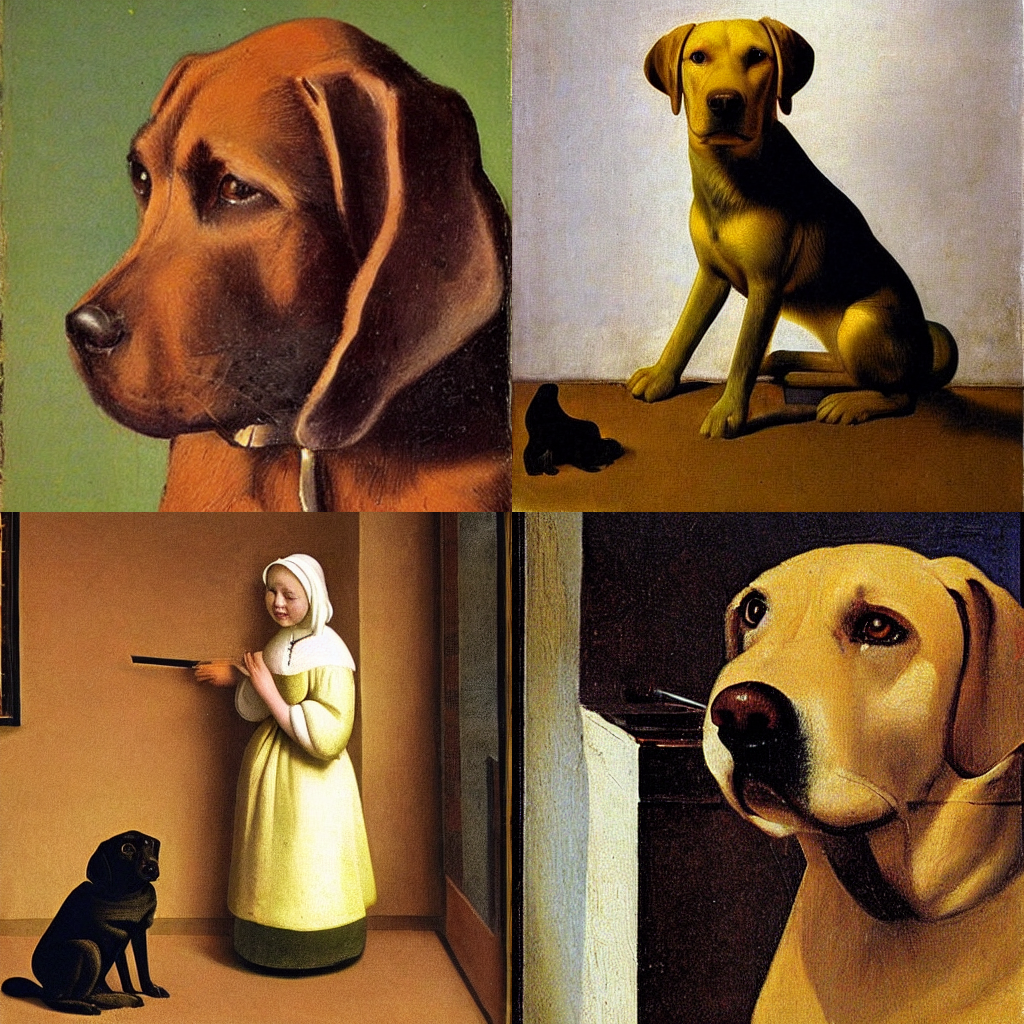

In [11]:
image_grid(images, 2, 2)

I like the second one! If we use the same seed we used before to regenerate those latents, we should get the same result.

In [12]:
seed = seeds[1]   # Second one
seed

6363507785059417

In [13]:
generator.manual_seed(seed)

latents = torch.randn(
    (1, pipe.unet.in_channels, height // 8, width // 8),
    generator = generator,
    device = device
)

We could just have reused `latents[1]` instead. But just taking note of the seeds will be enough te replicate the generation any time we like.

If we repeat the generation (of a single image) with these latents and the same prompt, we should get the same image as before:

0it [00:00, ?it/s]

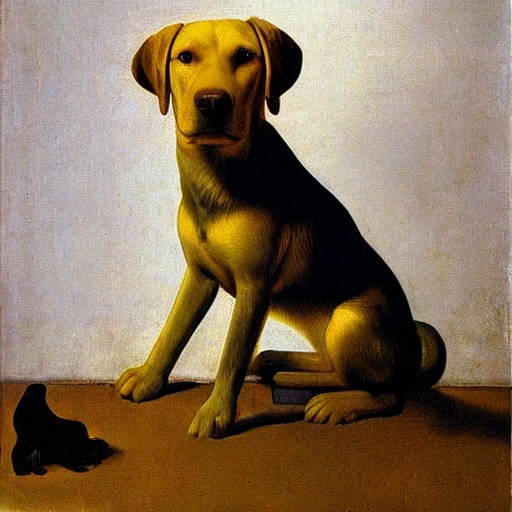

In [14]:
with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    )["sample"]
    
image[0]

It worked!

We can now try to tweak the prompt _keeping the same latents_. This should create an image with a similar structure but different content or style.

For example:

0it [00:00, ?it/s]

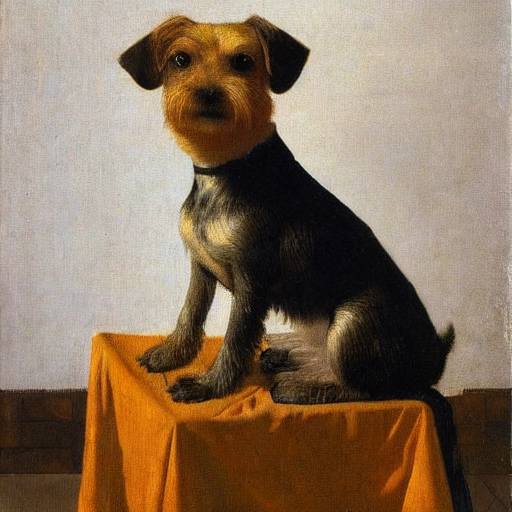

In [26]:
prompt = "Terrier in the style of Vermeer"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    )["sample"]
    
image[0]

0it [00:00, ?it/s]

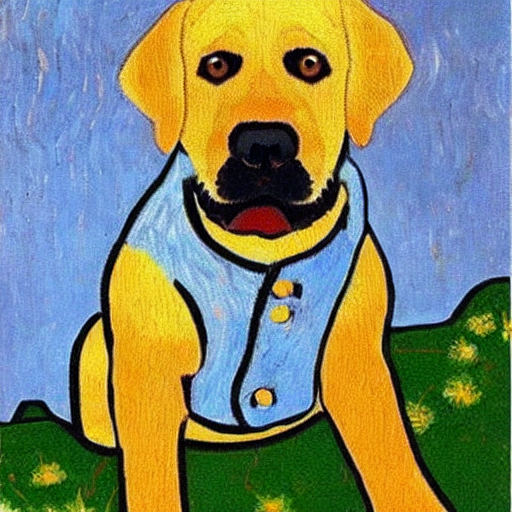

In [27]:
prompt = "Labrador in the style of Van Gogh"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    )["sample"]
    
image[0]

0it [00:00, ?it/s]

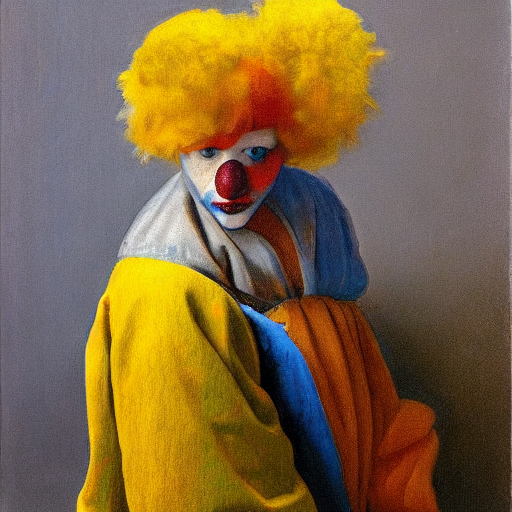

In [28]:
prompt = "Clown in the style of Vermeer"

with torch.autocast("cuda"):
    image = pipe(
        [prompt] * 1,
        guidance_scale=7.5,
        latents = latents,
    )["sample"]
    
image[0]